In [1]:
#######################################
# CS 424 - Project 3
# Kevin Kowalski
# Samuel Kajah
# Vijay Vemu
#######################################
#
# This file contains the code to clean
# the original data set. It outputs
# the necessary plots and updated data
# set to be used by shiny.
#
# This file was used for testing and 
# plotting before using RStudio for a
# dashboard.
#
#######################################

In [2]:
# import libraries
library(comprehenr)
library(dplyr)
library(ggplot2)
library(hashmap)
library(lubridate)
library(stringr)
library(tidyverse)

Warning message:
“package ‘comprehenr’ was built under R version 3.5.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


Warning message:
“package ‘stringr’ was built under R version 3.5.2”
Warning message:
“package ‘tidyverse’ was built under R version 3.5.2”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ purrr   0.3.3
✔ tidyr   1.0.0     ✔ forcats 0.4.0
✔ readr   1.3.1     

Warning message:
“package ‘tibble’ was built under R version 3.5.2”
Warning message:
“package ‘tidyr’ was built under R version 3.5.2”
Warning message:
“package ‘purrr’ was built under R version 3.5.2”
Warning message:
“package ‘forcats’ was bu

In [3]:
# read in the combined RDS file
data <- readRDS(file = "combined_data.rds")

# LEAVE COMMENTED, UNLESS YOU NEED TO REMAKE FILE
# keywords table only for movies found in combined data table
# df_keywords = read.csv('./data_files/new_files/keywords.csv')
# keywords_subset <- subset(df_keywords, movie %in% data$movie)
# write.csv(keywords_subset, file = 'keywords_subset.csv')

# read in the subsetted keywords CSV file
keywords_subset = read.csv('keywords_subset.csv')

In [4]:
# output number of entries in data
total_data <- count(data)
print(paste0("---- data, n=", total_data))
unique_films <- length(unique(data$movie))
print(paste0("---- unique movies, n=", unique_films))

[1] "---- data, n=334427"
[1] "---- unique movies, n=36596"


In [5]:
# get list of movies where none is duplicated (used for times where you only want to account for a movie once, such as runtime average)
unique_movies <- subset(data, !duplicated(subset(data, select = movie)))

In [6]:
# preview the top 5 rows
head(data, 5)

# get a random sample of 5 rows
sample_n(data, 5)

,movie,year,month,genre,runtime,rating
,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
214,#FollowFriday (2016),2016,September,Thriller,90,USA:Unrated
698,$ (1971),1971,December,Comedy,121,USA:R
700,$ (1971),1971,December,Crime,121,USA:R
702,$ (1971),1971,December,Drama,121,USA:R
714,$10 Raise (1935),1935,May,Comedy,70,USA:Approved


movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
The Tailor of Panama (2001),2001,July,Comedy,109,USA:R
Timber War (1935),1935,November,Western,60,USA:Passed
Ruby (1992),1992,July,Biography,95,USA:R
Miracle at St. Anna (2008),2008,December,War,160,USA:R
Dirty Rotten Scoundrels (1988),1988,December,Comedy,104,USA:PG


In [7]:
# get min and max years
min_year_all <- min(data$year)
max_year_all <- max(data$year)
print(paste0("---- years range from: ", min_year_all, "-", max_year_all))

[1] "---- years range from: 1912-2019"


In [8]:
# get min and max decades
min_decade_all <- floor(min(data$year) / 10) * 10
max_decade_all <- floor(max(data$year) / 10) * 10
print(paste0("---- decades range from: ", min_decade_all, "-", max_decade_all))

[1] "---- decades range from: 1910-2010"


In [9]:
# get min and max runtimes
min_runtime_all <- min(data$runtime)
max_runtime_all <- max(data$runtime)
print(paste0("---- runtimes range from: ", min_runtime_all, "-", max_runtime_all, " minutes"))

[1] "---- runtimes range from: 60-453 minutes"


In [10]:
############## COUNT/DISTRIBUTION TABLES BELOW ##############

In [11]:
# function to get a count of movies from each year as a table (same as above)
number_films_per_year = function(table) {
    
    # create empty dataframe of all years in range from calculated min to max
    all_years <- data.frame(formatC(min_year_all:max_year_all, width = 2), 0)
    names(all_years)[1] <- "year"
    names(all_years)[2] <- "count"
    all_years$year <- c(min_year_all:max_year_all)
    
    # make dataframe of available years and their frequency
    by_year <- table %>% group_by(year) %>% summarize(count = n())
    
    # join the counts into the full range of years dataframe
    by_year <- full_join(all_years, by_year, by = "year")
    by_year[is.na(by_year)] <- 0
    by_year$count.x <- NULL
    names(by_year)[2] <- "count"
    
    # output info
    total_films = as.numeric(sum(by_year$count))
    print(paste0("---- total counted= ", total_films))
    unique_years = as.numeric(count(by_year))
    print(paste0("---- unique years= ", unique_years))
    
    # return the table of counts per year
    by_year
}

# function to get a count of movies from each decade as a table
number_films_per_decade = function(table) {
    
    # create empty dataframe of each decade in range from calculated min to max
    all_decades <- data.frame(formatC(1:((max_decade_all - min_decade_all) / 10 + 1), width = 2), 0)
    names(all_decades)[1] <- "decade"
    names(all_decades)[2] <- "count"
    all_decades$decade <- seq(from = min_decade_all, to = max_decade_all, by = 10)
    
    # INEFFICIENT NESTED LOOP, IDEALLY A GROUP_BY OR SOMETHING BETTER
    # loop through each movie in given table
    for (row in 1:as.numeric(count(table))) {
        
        # get the current movie's decade it belongs to
        curr_decade = floor(table$year[row] / 10) * 10
        
        # loop through each decade
        for (i in 1:as.numeric(count(all_decades))) {
            
            # increment the decade count for found decade
            if (curr_decade == all_decades$decade[i]) {
                all_decades$count[i] <- all_decades$count[i] + 1
                break
            }
        }
    }
    
    # output info
    total_films = as.numeric(sum(all_decades$count))
    print(paste0("---- total counted= ", total_films))
    unique_decades = as.numeric(count(all_decades))
    print(paste0("---- unique decades= ", unique_decades))
    
    # return the table of counts per decade
    all_decades
}

# function to get a count of movies from each month as a table
number_films_per_month = function(table) {
    
    # get a count of movies from each month
    by_month <- table %>% group_by(month) %>% summarize(count = n())

    # reorder months to be in order
    by_month$month <- factor(by_month$month, levels = c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"))
    by_month <- by_month[order(by_month$month), ]

    # output info
    by_month
    print(paste0("---- total counted= ", sum(by_month$count)))
    unique_months = as.numeric(count(by_month))
    print(paste0("---- unique months= ", unique_months))
    
    # return the table of counts per month
    by_month
}

# function to get a distribution of runtimes as a table
distribution_of_runtimes = function(table) {
    
    # create empty dataframe of all runtimes in range from min to max
    all_runtimes <- data.frame(formatC(min_runtime_all:max_runtime_all, width = 2), 0)
    names(all_runtimes)[1] <- "runtime"
    names(all_runtimes)[2] <- "count"
    all_runtimes$runtime <- c(min_runtime_all:max_runtime_all)

    # make dataframe of available runtimes and their frequency
    by_runtime <- table %>% group_by(runtime) %>% summarize(count = n())

    # join the counts into the full range of years dataframe
    by_runtime <- full_join(all_runtimes, by_runtime, by = "runtime")
    by_runtime[is.na(by_runtime)] <- 0
    by_runtime$count.x <- NULL
    names(by_runtime)[2] <- "count"

    # output info
    head(by_runtime, 10)
    print(paste0("---- total counted= ", sum(by_runtime$count)))
    unique_runtimes = as.numeric(count(by_runtime))
    print(paste0("---- unique runtimes= ", unique_runtimes))
    
    # return the distribution of runtimes
    by_runtime
}

# function to get a distribution of certificates as a table
distribution_of_certificates = function(table) {
    
    # get a distribution of certificate
    by_certificates <- table %>% group_by(rating) %>% summarize(count = n())

    # output info
    print(paste0("---- total counted= ", sum(by_certificates$count)))
    unique_certificates = as.numeric(count(by_certificates))
    print(paste0("---- unique certificates= ", unique_certificates))
    
    # return the distribution of certificates
    by_certificates
}

# function to get a distribution of genres as a table
distribution_of_genres = function(table) {
    
    # get a distribution of genres
    by_genre <- table %>% group_by(genre) %>% summarize(count = n())

    # output info
    print(paste0("---- total counted= ", sum(by_genre$count)))
    unique_genres = as.numeric(count(by_genre))
    print(paste0("---- unique genres= ", unique_genres))
    
    # return the distribution of genres
    by_genre
}

# function to get a distribution of top n keywords as a table
distribution_of_keywords = function(table, n) {

    # get a distribution of top n keywords
    by_keywords <- table %>% group_by(keyword) %>% summarize(count = n())

    # output info
    by_keywords <- top_n(by_keywords, n) %>% arrange(desc(count))
    print(paste0("---- total counted= ", sum(by_keywords$count)))
    unique_keywords = as.numeric(count(by_keywords))
    print(paste0("---- unique keywords= ", unique_keywords))
    
    # return the distribution of top n keywords
    by_keywords
}


In [12]:
# get a count of movies from each year (for entire data (of unique movies))
by_year <- number_films_per_year(unique_movies)
sample_n(by_year, 5)

[1] "---- total counted= 36596"
[1] "---- unique years= 108"


year,count
<int>,<int>
1922,19
1953,350
1960,121
1930,183
2004,695


In [13]:
# get a count of movies from each decade (for entire data (of unique movies), takes a minute)
by_decade <- number_films_per_decade(unique_movies)
by_decade

[1] "---- total counted= 36596"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1910,34
1920,494
1930,3031
1940,3049
1950,2475
1960,1583
1970,3517
1980,3754
1990,4916


In [14]:
# get rows for a movie by partial name (can exclude year from its name)
# lots of movies have differing release months for some reason
# this SHOULD output 3 rows, 1 for each genre but many release months prevents this :(
jw2 <- data[str_detect(data$movie, "John Wick: Chapter 2"), ]
jw2

,movie,year,month,genre,runtime,rating
,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
1119397,John Wick: Chapter 2 (2017),2017,January,Action,122,USA:R
1119398,John Wick: Chapter 2 (2017),2017,February,Action,122,USA:R
1119462,John Wick: Chapter 2 (2017),2017,March,Action,122,USA:R
1119465,John Wick: Chapter 2 (2017),2017,April,Action,122,USA:R
1119466,John Wick: Chapter 2 (2017),2017,May,Action,122,USA:R
1119468,John Wick: Chapter 2 (2017),2017,July,Action,122,USA:R
1119469,John Wick: Chapter 2 (2017),2017,January,Crime,122,USA:R
1119470,John Wick: Chapter 2 (2017),2017,February,Crime,122,USA:R
1119534,John Wick: Chapter 2 (2017),2017,March,Crime,122,USA:R


In [15]:
# !!!
# since most movies have several months/genres as listed above, the leftover month
# from the unique_films table might not be correct so the months table below is skewed
# !!!

# get a count of movies from each month (for entire data (of unique movies))
by_month <- number_films_per_month(unique_movies)
by_month

[1] "---- total counted= 36596"
[1] "---- unique months= 12"


month,count
<fct>,<int>
January,3150
February,2511
March,3105
April,3082
May,3485
June,2651
July,2410
August,2921
September,4453


In [16]:
# get a distribution of runtimes
by_runtime <- distribution_of_runtimes(unique_movies)
sample_n(by_runtime, 5)

[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"


runtime,count
<dbl>,<dbl>
345,0
270,5
71,242
269,2
247,1


In [17]:
# get a distribution of certificate
by_certificates <- distribution_of_certificates(unique_movies)
by_certificates

[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"


rating,count
<fct>,<int>
USA:(Banned),1
USA:12,4
USA:AO,3
USA:Approved,6604
USA:G,1175
USA:GP,186
USA:Open,9
USA:Passed,2776
USA:PG,4418


In [18]:
# get a distribution of genres
by_genre <- distribution_of_genres(unique_movies)
by_genre

[1] "---- total counted= 36596"
[1] "---- unique genres= 22"


genre,count
<fct>,<int>
Action,6226
Adventure,2399
Animation,294
Biography,1172
Comedy,9399
Crime,2834
Documentary,1255
Drama,8243
Family,161


In [19]:
# get a distribution of top n keywords
n = 10
by_keywords <- distribution_of_keywords(keywords_subset, n)
by_keywords

Selecting by count



[1] "---- total counted= 56048"
[1] "---- unique keywords= 10"


keyword,count
<fct>,<int>
independent-film,8987
murder,8281
death,5430
female-nudity,5256
husband-wife-relationship,5138
violence,4920
based-on-novel,4738
blood,4523
cigarette-smoking,4398


In [20]:
############## AVERAGES BELOW ##############

In [21]:
# get average films per year, month, and average runtime

# average fims per year: sum of films divided by total years observed
#avg_per_year = trunc(total_films / unique_years)
unique_years = as.numeric(count(by_year))
avg_per_year = trunc(unique_films / unique_years)
print(paste0("---- avg films per year= ", avg_per_year))

# average films per month: sum of films each month, each sum divided by total years observed; then average these results
unique_months = as.numeric(count(by_month))
avg_by_month <- by_month
avg_by_month$count <- by_month$count / unique_years
names(avg_by_month)[2] <- "average"
avg_per_month = trunc(as.numeric(sum(avg_by_month$average) / unique_months))
print(paste0("---- avg films per month= ", avg_per_month))
avg_by_month

# average runtime: sum of each runtime divided by total runtime observations
avg_runtime = trunc(mean(unique_movies$runtime))
print(paste0("---- avg runtime= ", avg_runtime))

[1] "---- avg films per year= 338"
[1] "---- avg films per month= 28"


month,average
<fct>,<dbl>
January,29.16667
February,23.25000
March,28.75000
April,28.53704
May,32.26852
June,24.54630
July,22.31481
August,27.04630
September,41.23148


[1] "---- avg runtime= 95"


In [22]:
############## CHOOSE YEAR OR DECADE ##############

In [23]:
# get items by year
selected_year = 2011

# USE THIS ONE TO FETCH MOVIES BY YEAR FROM THEIR NAME (I noticed some movies have a different year than in the name, but possibly not in this combined table)
# movie year found in movie name i.e. "{Title} (2014)" or "{Title} (2014/I)", extract year via pattern matching because year column is inaccurate for some reason
#regex_year = paste0("\\(", selected_year, "\\)|\\(", selected_year, "\\/")
#movies_in_selected_year <- subset(data, grepl(regex_year, movie))

# fetch the movies by the selected year
movies_in_selected_year <- subset(data, year == selected_year)

# output a sample of movies found for given year
sample_n(movies_in_selected_year, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Coriolanus (2011),2011,October,Thriller,123,USA:R
La femme du Vème (2011),2011,November,Thriller,84,USA:R
Orla Frøsnapper (2011),2011,June,Family,78,USA:PG
Intouchables (2011),2011,September,Drama,112,USA:R
Mein bester Feind (2011),2011,February,Drama,95,USA:Unrated
Mein bester Feind (2011),2011,February,War,109,USA:Unrated
Anaganaga O Dheerudu (2011),2011,January,Adventure,133,USA:PG-13
Perfect Sense (2011),2011,August,Romance,92,USA:R
The Son of No One (2011),2011,January,Drama,90,USA:R


In [24]:
# get items by decade (where decades are in format of 1990, 2000, 2010, etc... for next 9 years, i.e. 1990-1999, 2000-2009, etc..)
selected_decade = 2010

# USE THIS ONE TO FETCH MOVIES BY YEAR FROM THEIR NAME
# movie year found in movie name i.e. "{Title} (2014)" or "{Title} (2014/I)", extract decade via pattern matching for decade + 9
#regex_decade = paste0("\\(", selected_decade / 10, "[0-9]\\)|\\(", selected_decade / 10, "[0-9]\\/")
#movies_in_selected_decade <- subset(data, grepl(regex_decade, movie))

# fetch the movies by the selected year
movies_in_selected_decade <- subset(data, year >= selected_decade & year < selected_decade + 10)

# output a sample of movies found for given year
sample_n(movies_in_selected_decade, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Dominium (2013),2013,December,Horror,75,USA:R
YellowBrickRoad (2010),2010,October,Horror,98,USA:R
11-11-11 (2011),2011,December,Thriller,90,USA:PG-13
Vamps (2012),2012,December,Horror,92,USA:PG-13
Amityville: The Awakening (2017),2017,October,Thriller,85,USA:PG-13
Mr. Peabody & Sherman (2014),2014,April,Animation,92,USA:PG
Thunder Soul (2010),2010,August,Music,83,USA:PG
Your Highness (2011),2011,June,Fantasy,102,USA:R
The Host (2013),2013,July,Action,125,USA:PG-13


In [25]:
############## CHOOSE GENRE ##############

In [26]:
# genre input is comma separated string list
selected_genres = "comedy, Drama , fake_test, doCumenTarY, "

# split genres input to individual inputs
genres <- unlist(strsplit(selected_genres, ","))

# retrieve first genre as a "base"
condition <- paste0("str_to_lower(str_trim(genres[1])) == str_to_lower(genre) ")

# if more than 1 genres provided...
if (length(genres) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(genres)) {
        
        # make a new condition with the current genre, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(genres[", i, "])) == str_to_lower(genre) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie genre found in genre column, just fetch it by parsing the condition from above
movies_in_selected_genre <- subset(data, eval(parse(text = condition)))

# output a sample of movies found for given genre(s)
sample_n(movies_in_selected_genre, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Bahama Passage (1941),1941,December,Drama,82,USA:Passed
Hello-Goodbye (1970),1970,November,Comedy,101,USA:GP
The Hollars (2016),2016,August,Comedy,88,USA:PG-13
American Pie (1999),1999,July,Comedy,95,USA:Unrated
The Bleeder (2016),2016,December,Drama,98,USA:R
Planet B-Boy (2007),2007,April,Documentary,95,USA:Unrated
Star! (1968),1968,July,Drama,176,USA:G
Without a Trace (1983),1983,November,Drama,116,USA:PG
When the Bough Breaks (2016),2016,September,Drama,107,USA:PG-13


In [27]:
# number of films released in selected genre
number_in_genre <- length(unique(movies_in_selected_genre$movie))
print(paste0("---- films in genre= ", number_in_genre))

[1] "---- films in genre= 27448"


In [28]:
# table above can have duplicate movies due to movies having multiple genres or months
# get a subset of those movies where a movie only appears once
unique_movies_in_genre <- subset(movies_in_selected_genre, !duplicated(subset(movies_in_selected_genre, select = movie)))

# table of "number of films released in that genre each year" (total_counted value should match number_in_x value)
films_per_year_by_selected_genre <- number_films_per_year(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_year_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique years= 108"


year,count
<int>,<dbl>
1974,262
1949,192
1952,169
1936,259
1970,291


In [29]:
# get "percentage of films released in that genre each year"

# add total films per year to table and calculuate percentage
films_per_year_by_selected_genre$total <- by_year$count
films_per_year_by_selected_genre$percent <- (films_per_year_by_selected_genre$count / by_year$count) * 100

# output a sample of 5 rows
sample_n(films_per_year_by_selected_genre, 5)

year,count,total,percent
<int>,<dbl>,<int>,<dbl>
2009,649,879,73.83390
1947,236,320,73.75000
1936,259,348,74.42529
1972,279,387,72.09302
2015,611,791,77.24399


In [30]:
# table of "number of films released in that genre each decade" (total_counted value should match number_in_x value)
films_per_decade_by_selected_genre <- number_films_per_decade(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_decade_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1970,2613
1910,23
1940,2288
1990,3760
2000,5915


In [31]:
# get "percentage of films released in that genre each decade"

# add total films per decade to table and calculuate percentage
films_per_decade_by_selected_genre$total <- by_decade$count
films_per_decade_by_selected_genre$percent <- (films_per_decade_by_selected_genre$count / by_decade$count) * 100

# show output
films_per_decade_by_selected_genre

decade,count,total,percent
<dbl>,<dbl>,<dbl>,<dbl>
1910,23,34,67.64706
1920,394,494,79.75709
1930,2379,3031,78.48895
1940,2288,3049,75.04100
1950,1549,2475,62.58586
1960,1135,1583,71.69931
1970,2613,3517,74.29628
1980,2758,3754,73.46830
1990,3760,4916,76.48495


In [32]:
# table of "number of films released in that genre each month" (total_counted value should match number_in_x value)
films_per_month_by_selected_genre <- number_films_per_month(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_month_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique months= 12"


month,count
<fct>,<int>
March,2293
August,2129
February,1906
June,1971
November,1977


In [33]:
# get "percentage of films released in that genre each month"

# add total films per month to table and calculuate percentage
films_per_month_by_selected_genre$total <- by_month$count
films_per_month_by_selected_genre$percent <- (films_per_month_by_selected_genre$count / by_month$count) * 100

# show output
films_per_month_by_selected_genre

month,count,total,percent
<fct>,<int>,<int>,<dbl>
January,2501,3150,79.39683
February,1906,2511,75.90601
March,2293,3105,73.84863
April,2289,3082,74.26995
May,2673,3485,76.70014
June,1971,2651,74.34930
July,1645,2410,68.25726
August,2129,2921,72.88600
September,3574,4453,80.26050


In [34]:
# table of "distribution of running times of films in that genre" (total_counted value should match number_in_x value)
distribution_runtimes_by_selected_genre <- distribution_of_runtimes(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(distribution_runtimes_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique runtimes= 395"


runtime,count
<dbl>,<dbl>
195,3
432,0
102,527
209,0
161,6


In [35]:
# table of "distribution of certificates in that genre" (total_counted value should match number_in_x value)
distribution_certificates_by_selected_genre <- distribution_of_certificates(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(distribution_certificates_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique certificates= 12"


rating,count
<fct>,<int>
USA:AO,3
USA:(Banned),1
USA:Approved,4800
USA:Open,6
USA:GP,150


In [36]:
# table of "distribution of top n keywords in that genre"

# keywords table only for movies found in selected_genre
keywords_subset_for_genre <- subset(keywords_subset, movie %in% movies_in_selected_genre$movie)

top_N = 10
distribution_keywords_by_selected_genre <- distribution_of_keywords(keywords_subset_for_genre, top_N)

# output a sample of 10 rows
sample_n(distribution_keywords_by_selected_genre, 10)

Selecting by count



[1] "---- total counted= 41369"
[1] "---- unique keywords= 10"


keyword,count
<fct>,<int>
character-name-in-title,3325
death,3725
father-daughter-relationship,3233
murder,5112
cigarette-smoking,3621
female-nudity,4003
based-on-novel,3730
independent-film,6555
father-son-relationship,3703


In [37]:
############## CHOOSE KEYWORD ##############

In [38]:
# keyword input is comma separated string list
selected_keywords = "fight, cat-and-mouse , fake_test, shOtguN, "

# split keyword input to individual inputs
keywords <- unlist(strsplit(selected_keywords, ","))

# retrieve first keyword as a "base"
condition <- paste0("str_to_lower(str_trim(keywords[1])) == str_to_lower(keyword) ")

# if more than 1 keywords provided...
if (length(keywords) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(keywords)) {
        
        # make a new condition with the current keyword, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(keywords[", i, "])) == str_to_lower(keyword) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie keyword found in keyword column, just fetch it by parsing the condition from above
movies_in_selected_keywords <- subset(keywords_subset, eval(parse(text = condition)))

# output a sample of movies found for given keyword(s)
sample_n(movies_in_selected_keywords, 10)

X,movie,keyword,year
<int>,<fct>,<fct>,<int>
774043,Detonator (2003),fight,2003
2975588,The Deadly Trackers (1973),shotgun,1973
2362605,Quand on a 17 ans (2016),fight,2016
2746813,Stop-Loss (2008),fight,2008
1853836,Maggie (2015/I),shotgun,2015
3389052,This Means War (2012),shotgun,2012
844862,Downtown (1990),shotgun,1990
952395,Evelyn (2002),fight,2002
1861851,Make Your Own Bed (1944),shotgun,1944


In [74]:
# number of films released in selected keyword
number_in_keywords <- length(unique(movies_in_selected_keywords$movie))

In [80]:
unique_movies_in_keywords <- subset(movies_in_selected_keywords, !duplicated(subset(movies_in_selected_keywords, select = movie)))

# table of "number of films released in that keyword each year" (total_counted value should match number_in_x value)
films_per_year_by_selected_keywords <- number_films_per_year(unique_movies_in_keywords)

# output a sample of 5 rows
sample_n(films_per_year_by_selected_keywords, 5)

[1] "---- total counted= 3971"
[1] "---- unique years= 108"


year,count
<int>,<dbl>
2003,105
2015,81
2019,0
2016,96
1947,13


In [79]:
# get "percentage of films released in that keyword each year"

# add total films per year to table and calculuate percentage
films_per_year_by_selected_keywords$total <- by_year$count
films_per_year_by_selected_keywords$percent <- (films_per_year_by_selected_keywords$count / by_year$count) * 100

# output a sample of 5 rows
sample_n(films_per_year_by_selected_keywords, 5)

year,count,total,percent
<int>,<dbl>,<int>,<dbl>
1954,7,258,2.713178
1946,8,303,2.640264
1951,5,289,1.730104
2006,105,855,12.280702
1957,5,226,2.212389


In [81]:
# table of "number of films released in that keyword each decade" (total_counted value should match number_in_x value)
films_per_decade_by_selected_keywords <- number_films_per_decade(unique_movies_in_keywords)

# output a sample of 5 rows
sample_n(films_per_decade_by_selected_keywords, 5)

[1] "---- total counted= 3971"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1950,98
1930,189
1960,109
1990,706
2000,1109


In [82]:
# get "percentage of films released in that keyword each decade"

# add total films per decade to table and calculuate percentage
films_per_decade_by_selected_keywords$total <- by_decade$count
films_per_decade_by_selected_keywords$percent <- (films_per_decade_by_selected_keywords$count / by_decade$count) * 100

# show output
films_per_decade_by_selected_keywords

decade,count,total,percent
<dbl>,<dbl>,<dbl>,<dbl>
1910,1,34,2.941176
1920,15,494,3.036437
1930,189,3031,6.235566
1940,167,3049,5.477206
1950,98,2475,3.959596
1960,109,1583,6.885660
1970,369,3517,10.491897
1980,492,3754,13.106020
1990,706,4916,14.361269


In [84]:
# table of "number of films released in that genre each month" (total_counted value should match number_in_x value)
films_per_month_by_selected_keywords <- number_films_per_month(unique_movies_in_keywords)

# output a sample of 5 rows
sample_n(films_per_month_by_selected_keywords, 5)

ERROR: Error: Column `month` is unknown


In [39]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [40]:
############## CHOOSE CERTIFICATE ##############

In [41]:
# certificate input is comma separated string list
selected_certificates = "USA:Pg-13, USA:UnRateD , USA:fake_test, USA:, "

# split certificate input to individual inputs
certificates <- unlist(strsplit(selected_certificates, ","))

# retrieve first certificate as a "base"
condition <- paste0("str_to_lower(str_trim(certificates[1])) == str_to_lower(rating) ")

# if more than 1 certificates provided...
if (length(certificates) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(certificates)) {
        
        # make a new condition with the current certificate, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(certificates[", i, "])) == str_to_lower(rating) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie certificate found in certificate column, just fetch it by parsing the condition from above
movies_in_selected_certificates <- subset(data, eval(parse(text = condition)))

# output a sample of movies found for given certificate(s)
sample_n(movies_in_selected_certificates, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Valentín (2002/I),2002,September,Romance,79,USA:PG-13
Better Than Chocolate (1999),1999,August,Drama,101,USA:Unrated
The Raspberry Reich (2004),2004,October,Comedy,90,USA:Unrated
The Twilight Saga: Breaking Dawn - Part 2 (2012),2012,December,Fantasy,115,USA:PG-13
The Scorpion King (2002),2002,June,Fantasy,100,USA:PG-13
Boys and Girls (2000),2000,September,Comedy,94,USA:PG-13
The Box (2009/I),2009,October,Thriller,115,USA:PG-13
Austin Powers: International Man of Mystery (1997),1997,December,Comedy,89,USA:PG-13
There Be Dragons (2011),2011,June,Biography,106,USA:PG-13


In [42]:
# Number of films released in selected certificate #
number_in_certificate <- length(unique(movies_in_selected_certificates$movie))

In [43]:
# Although certificates won't repeat, we just wanted to stay consistent with the data tables 
# so we eliminated duplicates in case there are any
unique_movies_in_certificate <- subset(movies_in_selected_certificates, !duplicated(subset(movies_in_selected_certificates, select = movie)))

# table of "number of films released in that certificate each year" (total_counted value should match number_in_x value)
films_per_year_by_selected_certificate <- number_films_per_year(unique_movies_in_certificate)

[1] "---- total counted= 7545"
[1] "---- unique years= 108"


In [44]:
# get "percentage of films released in that certificate each year"

# add total films per year to table and calculuate percentage
films_per_year_by_selected_certificate$total <- by_year$count
films_per_year_by_selected_certificate$percent <- (films_per_year_by_selected_certificate$count / by_year$count) * 100

In [45]:
# table of "number of films released in that certificate each decade" (total_counted value should match number_in_x value)
films_per_decade_by_selected_certificate <- number_films_per_decade(unique_movies_in_certificate)

# get "percentage of films released in that certificate each decade"

# add total films per decade to table and calculuate percentage
films_per_decade_by_selected_certificate$total <- by_decade$count
films_per_decade_by_selected_certificate$percent <- (films_per_decade_by_selected_certificate$count / by_decade$count) * 100

# show output
films_per_decade_by_selected_certificate

[1] "---- total counted= 7545"
[1] "---- unique decades= 11"


decade,count,total,percent
<dbl>,<dbl>,<dbl>,<dbl>
1910,10,34,29.411765
1920,34,494,6.882591
1930,89,3031,2.936325
1940,56,3049,1.836668
1950,147,2475,5.939394
1960,318,1583,20.088440
1970,164,3517,4.663065
1980,605,3754,16.116143
1990,1158,4916,23.555736


In [46]:
# table of "number of films released in that certificate each month" (total_counted value should match number_in_x value)
films_per_month_by_selected_certificate <- number_films_per_month(unique_movies_in_certificate)

# output
films_per_month_by_selected_certificate

# get "percentage of films released in that certificate each month"

# add total films per month to table and calculuate percentage
films_per_month_by_selected_certificate$total <- by_month$count
films_per_month_by_selected_certificate$percent <- (films_per_month_by_selected_certificate$count / by_month$count) * 100

# show output
films_per_month_by_selected_certificate

[1] "---- total counted= 7545"
[1] "---- unique months= 12"


month,count
<fct>,<int>
January,654
February,563
March,635
April,676
May,713
June,579
July,462
August,596
September,1014


month,count,total,percent
<fct>,<int>,<int>,<dbl>
January,654,3150,20.76190
February,563,2511,22.42135
March,635,3105,20.45089
April,676,3082,21.93381
May,713,3485,20.45911
June,579,2651,21.84081
July,462,2410,19.17012
August,596,2921,20.40397
September,1014,4453,22.77117


In [47]:
# table of "distribution of running times of films in that certificate" (total_counted value should match number_in_x value)
distribution_runtimes_by_selected_certificate <- distribution_of_runtimes(unique_movies_in_certificate)

# table of "distribution of genre in that certificate" (total_counted value should match number_in_x value)
distribution_genres_by_selected_certificate <- distribution_of_genres(unique_movies_in_certificate)

distribution_genres_by_selected_certificate

# keywords table only for movies found in selected_genre
keywords_subset_for_certificate <- subset(keywords_subset, movie %in% movies_in_selected_certificates$movie)

top_N = 5
distribution_keywords_by_selected_certificate <- distribution_of_keywords(keywords_subset_for_certificate, top_N)

# output a sample of 10 rows
#sample_n(distribution_keywords_by_selected_certificate, 5)

[1] "---- total counted= 7545"
[1] "---- unique runtimes= 394"
[1] "---- total counted= 7545"
[1] "---- unique genres= 22"


genre,count
<fct>,<int>
Action,1233
Adventure,324
Animation,47
Biography,345
Comedy,2070
Crime,314
Documentary,519
Drama,1902
Family,18


Selecting by count



[1] "---- total counted= 6321"
[1] "---- unique keywords= 5"


In [48]:
############## CHOOSE RUNTIME ##############

In [49]:
# runtime input is range from min to max
runtime_min = 60
runtime_max = 120

# movie runtime found in runtime column, just fetch it and compare the inputs
movies_in_selected_runtimes <- subset(data, runtime_min <= runtime & runtime_max >= runtime)

# output a sample of movies found for given runtime range
sample_n(movies_in_selected_runtimes, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Jack Slade (1953),1953,December,Western,90,USA:Approved
Connie and Carla (2004),2004,November,Crime,108,USA:PG-13
I Want a Divorce (1940),1940,September,Drama,75,USA:Approved
Who's That Girl (1987),1987,October,Music,92,USA:PG
Loch Ness (1996),1996,September,Mystery,101,USA:PG
Coma (1978),1978,June,Drama,104,USA:PG
Macbeth in Manhattan (1999),1999,October,Drama,97,USA:R
Lung hing foo dai (1986),1986,September,Action,88,USA:R
The Apple (1980),1980,October,Sci-Fi,90,USA:PG


In [71]:
# Number of films released in selected runtime #
number_in_runtime <- length(unique(movies_in_selected_runtimes$movie))

unique_movies_in_runtime <- subset(movies_in_selected_runtimes, !duplicated(subset(movies_in_selected_runtimes, select = movie)))

# table of "number of films released in that runtime each year" (total_counted value should match number_in_x value)
films_per_year_by_selected_runtime <- number_films_per_year(unique_movies_in_runtime)

[1] "---- total counted= 34002"
[1] "---- unique years= 108"


In [72]:
# get "percentage of films released in that runtime each year"

# add total films per year to table and calculuate percentage
films_per_year_by_selected_runtime$total <- by_year$count
films_per_year_by_selected_runtime$percent <- (films_per_year_by_selected_runtime$count / by_year$count) * 100

In [73]:
# table of "number of films released in that runtime each decade" (total_counted value should match number_in_x value)
films_per_decade_by_selected_runtime <- number_films_per_decade(unique_movies_in_runtime)

# get "percentage of films released in that runtime each decade"

# add total films per decade to table and calculuate percentage
films_per_decade_by_selected_runtime$total <- by_decade$count
films_per_decade_by_selected_runtime$percent <- (films_per_decade_by_selected_runtime$count / by_decade$count) * 100

# show output
films_per_decade_by_selected_runtime

[1] "---- total counted= 34002"
[1] "---- unique decades= 11"


decade,count,total,percent
<dbl>,<dbl>,<dbl>,<dbl>
1910,32,34,94.11765
1920,471,494,95.34413
1930,2925,3031,96.50280
1940,2901,3049,95.14595
1950,2372,2475,95.83838
1960,1373,1583,86.73405
1970,3314,3517,94.22804
1980,3538,3754,94.24614
1990,4501,4916,91.55818


In [ ]:
# table of "number of films released in that runtime each month" (total_counted value should match number_in_x value)
films_per_month_by_selected_runtime <- number_films_per_month(unique_movies_in_runtime)

# output
films_per_month_by_selected_runtime

# get "percentage of films released in that runtime each month"

# add total films per month to table and calculuate percentage
films_per_month_by_selected_runtime$total <- by_month$count
films_per_month_by_selected_runtime$percent <- (films_per_month_by_selected_runtime$count / by_month$count) * 100

# show output
films_per_month_by_selected_runtime

In [ ]:
# table of "distribution of certificates of films in that runtime" (total_counted value should match number_in_x value)
distribution_certificate_by_selected_runtime <- distribution_of_certificates(unique_movies_in_runtime)

# table of "distribution of genre in that runtime" (total_counted value should match number_in_x value)
distribution_genres_by_selected_runtime <- distribution_of_genres(unique_movies_in_runtime)

distribution_genres_by_selected_runtime
distribution_certificate_by_selected_runtime

# keywords table only for movies found in selected runtime
keywords_subset_for_runtime <- subset(keywords_subset, movie %in% movies_in_selected_runtimes$movie)

top_N = 5
distribution_keywords_by_selected_runtime <- distribution_of_keywords(keywords_subset_for_certificate, top_N)

# output a sample of 5 rows
sample_n(distribution_keywords_by_selected_runtime, 5)

In [51]:
############## PLOTS ##############

[1] "---- total counted= 36596"
[1] "---- unique years= 108"


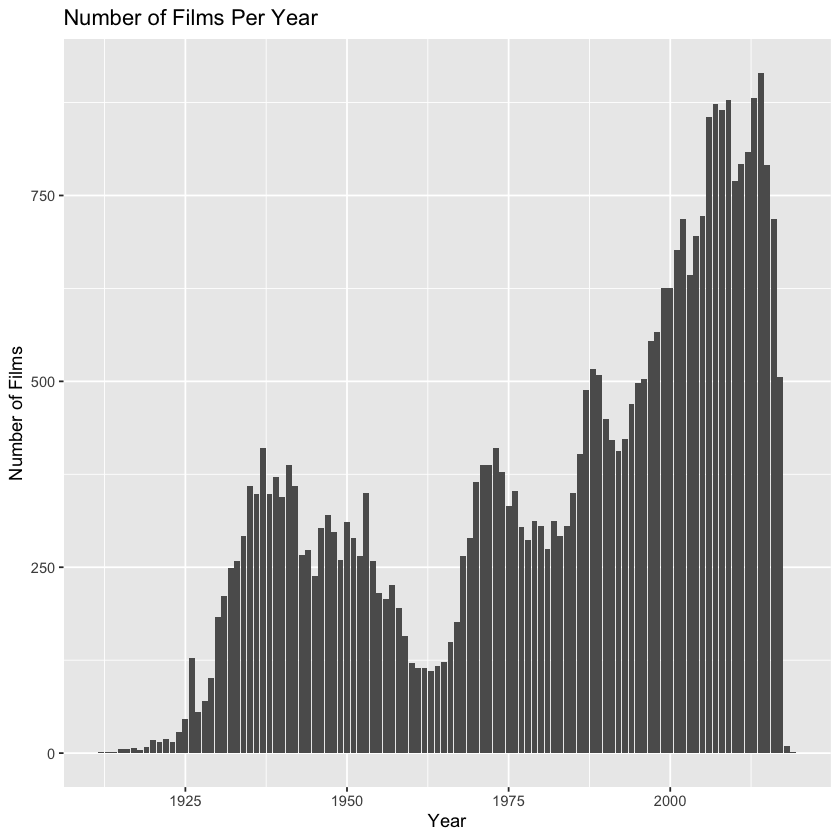

In [52]:
## Bar chart for films released per year## 

films_per_year_graph = number_films_per_year(unique_movies)
ggplot(films_per_year_graph, aes(x=year, y=count)) +
  geom_bar(stat = "identity", fill = "gray36") + labs(title = "Number of Films Per Year", x = "Year", y = "Number of Films")

In [53]:
## Bar chart for films released per month## 

plotMonthPerGivenYear <- function(data, year)
{
    monthly_films_all = number_films_per_month(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        ggplot(monthly_films_all, aes(x=month, y=count)) +
        geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Monthly Distribution", x = "Month", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        monthly_films_year = number_films_per_month(year_films) %>% mutate(compare=year)
        
        monthly_films_all = monthly_films_all %>% mutate(compare='All')
        
        combined_data = rbind(monthly_films_year, monthly_films_all)
        
        ggplot(combined_data, aes(x=month, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Monthly Distribution", x = "Month", y = "Number of Films")
        
    }
}    

[1] "---- total counted= 36596"
[1] "---- unique months= 12"
[1] "---- total counted= 769"
[1] "---- unique months= 12"
[1] "---- total counted= 36596"
[1] "---- unique months= 12"


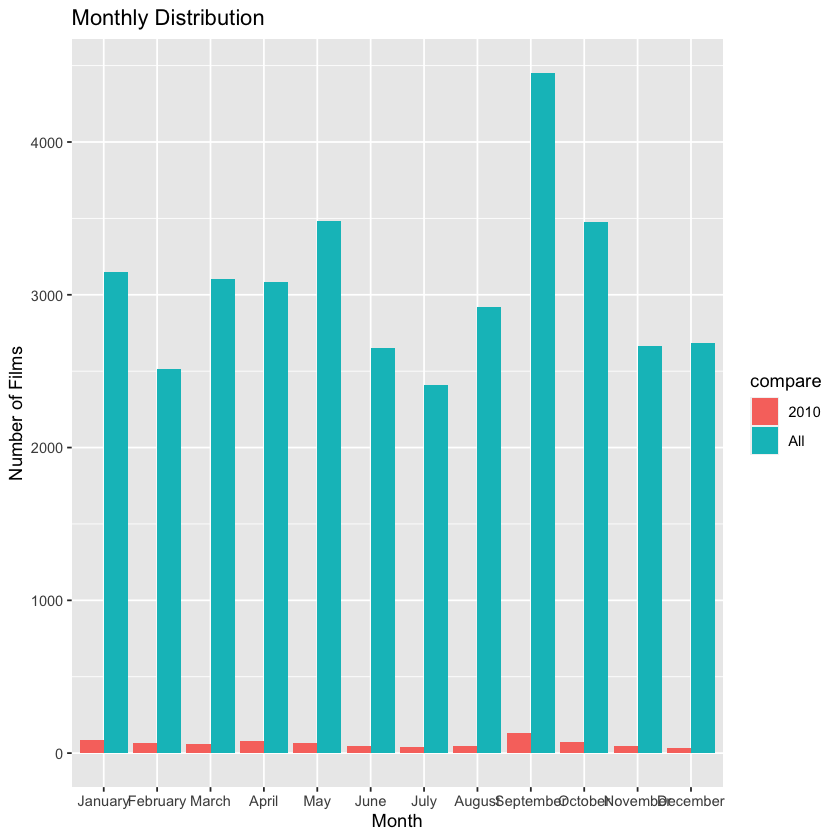

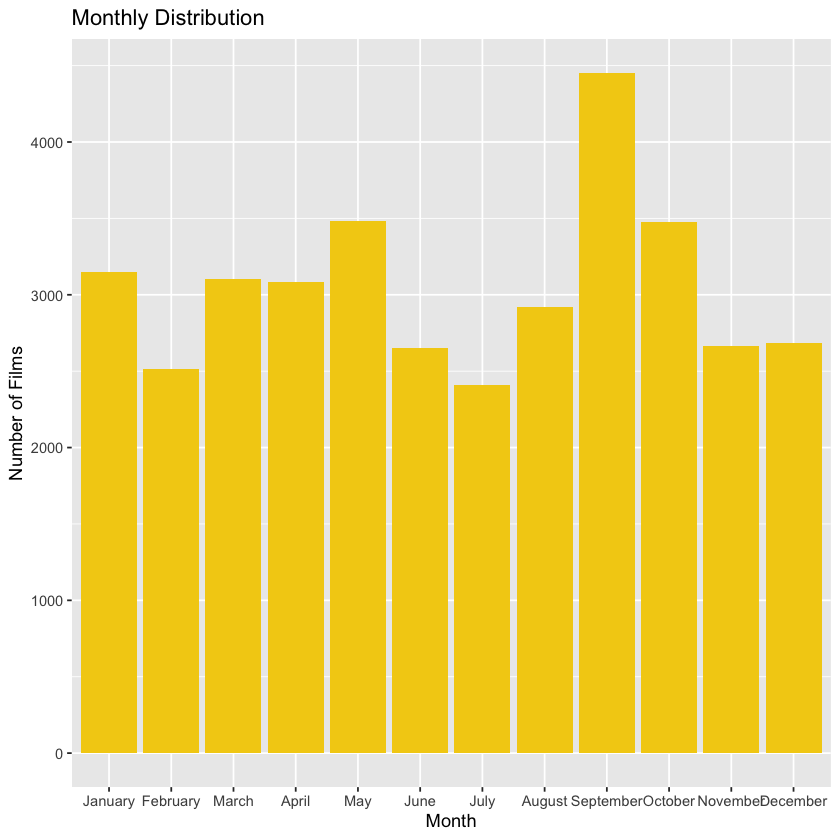

In [54]:
plotMonthPerGivenYear(unique_movies, 2010)
plotMonthPerGivenYear(unique_movies, NULL)

In [55]:
## Bar chart for distribution runtimes##

plotRuntimePerGivenYear <- function(data, year)
{
    runtime_distribution_all = distribution_of_runtimes(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        ggplot(runtime_distribution_all, aes(x=runtime, y=count)) +
        geom_point() + labs(title = "Runtime Distribution", x = "Runtime", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        runtime_distribution_year =  distribution_of_runtimes(year_films) %>% mutate(compare=year)
        
        runtime_distribution_all = runtime_distribution_all %>% mutate(compare='All')
        
        combined_data = rbind(runtime_distribution_year, runtime_distribution_all)
        
        ggplot(combined_data, aes(x=runtime, y=count, color=compare)) +
        geom_point() + labs(title = "Runtime Distribution", x = "Runtime", y = "Number of Films")
        
    }
    
}


[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"
[1] "---- total counted= 769"
[1] "---- unique runtimes= 394"
[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"


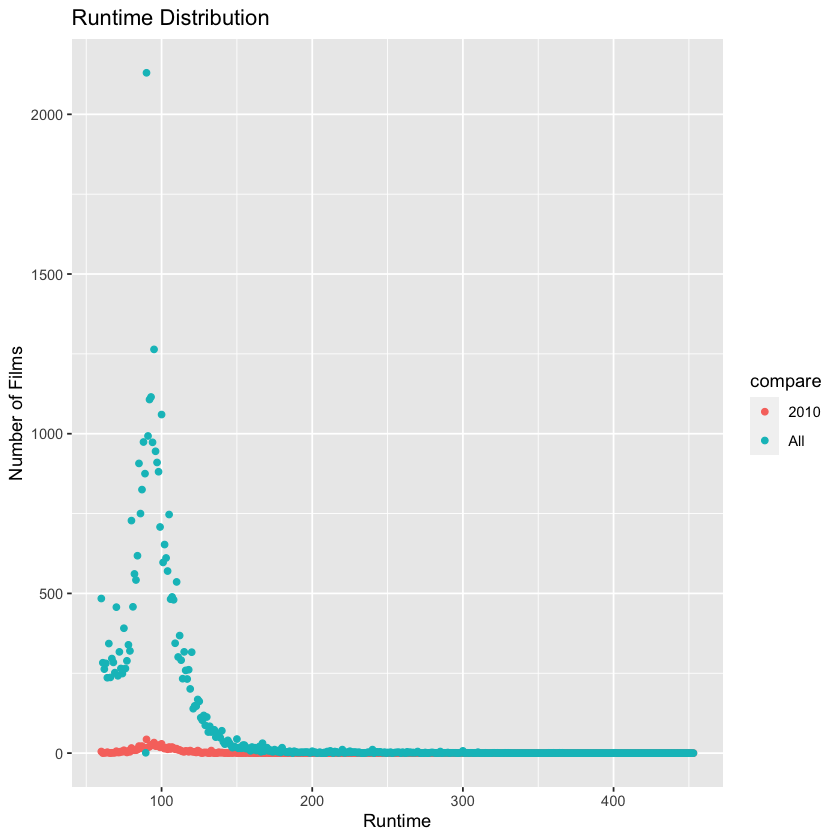

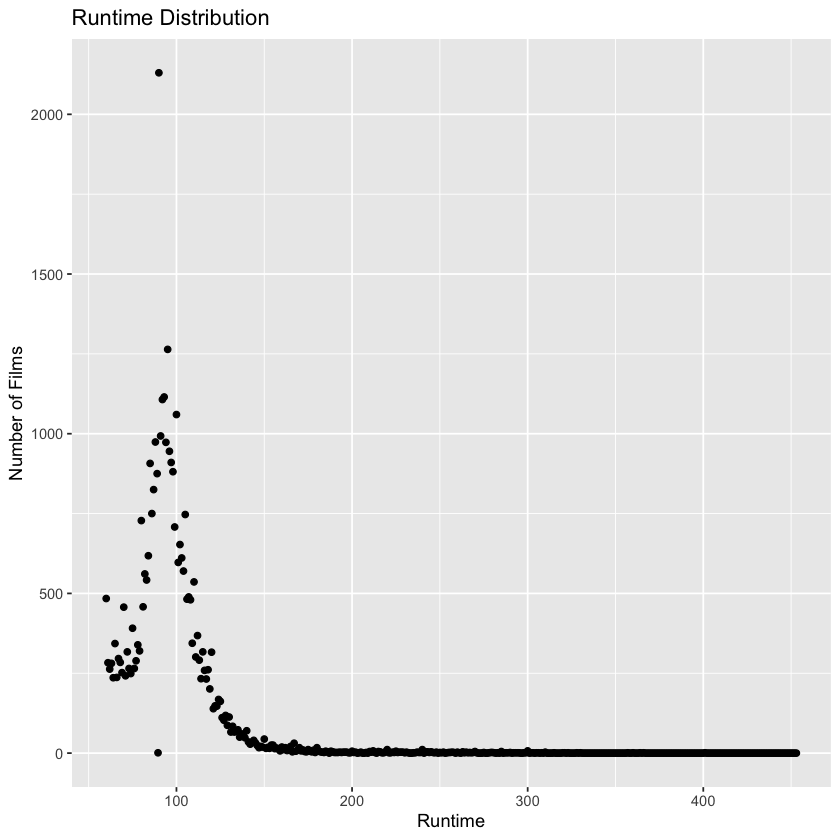

In [56]:
plotRuntimePerGivenYear(unique_movies, 2010)
plotRuntimePerGivenYear(unique_movies, NULL)

In [69]:
## Bar chart for distribution of genres ##

plotGenrePerYear <- function(data, year)
{
    genre_distribution_all = distribution_of_genres(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        ggplot(genre_distribution_all, aes(x=genre, y=count)) +
        geom_bar(stat='identity') + labs(title = "Genre Distribution", x = "Genre", y = "Number of Films") + coord_flip()
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        genre_distribution_year =  distribution_of_genres(year_films) %>% mutate(compare=year)
        
        genre_distribution_all = genre_distribution_all %>% 
                                filter(genre %in% genre_distribution_year$genre) %>% 
                                mutate(compare='All')
        
        combined_data = rbind(genre_distribution_year, genre_distribution_all)
        
        ggplot(combined_data, aes(x=genre, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Genre Distribution", x = "Genre", y = "Number of Films") + coord_flip()
        
    }
}

[1] "---- total counted= 36596"
[1] "---- unique genres= 22"
[1] "---- total counted= 809"
[1] "---- unique genres= 17"
[1] "---- total counted= 36596"
[1] "---- unique genres= 22"


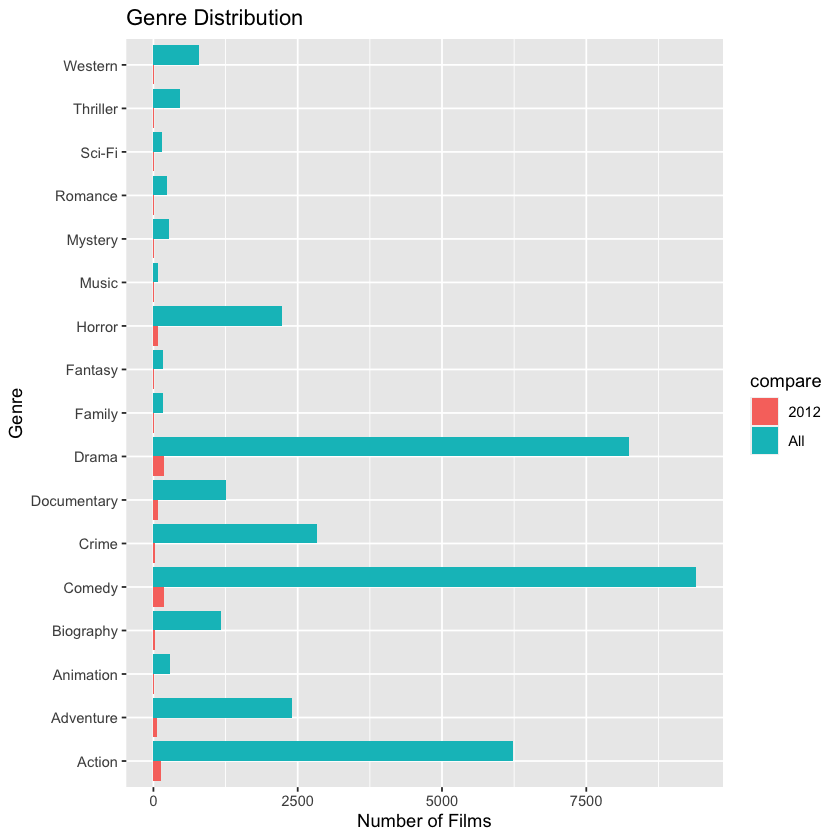

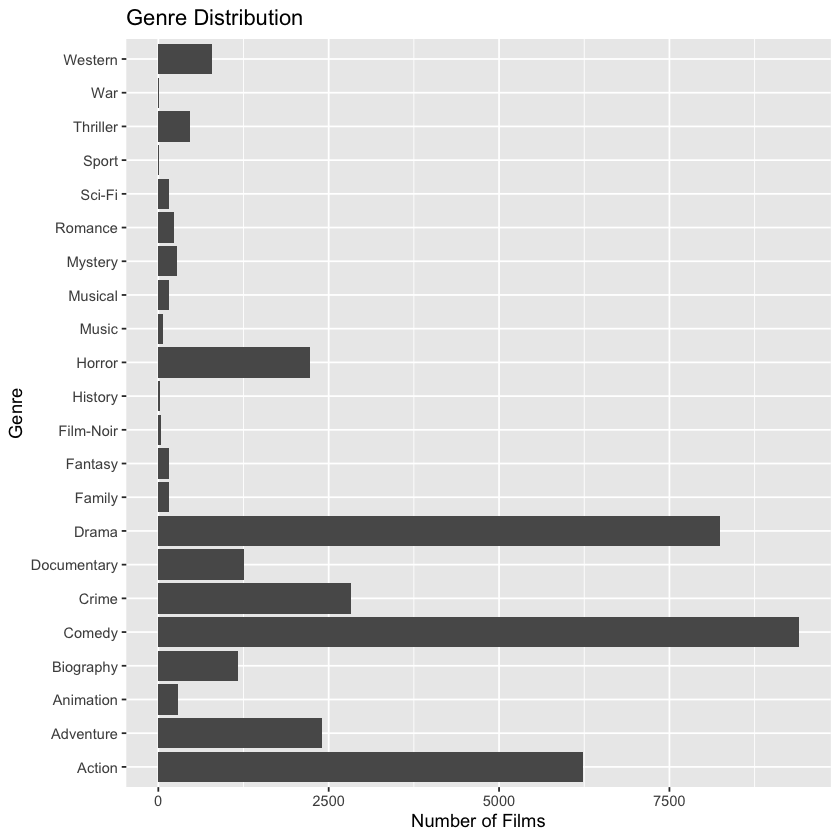

In [70]:
plotGenrePerYear(unique_movies, 2012)
plotGenrePerYear(unique_movies, NULL)

In [59]:
## Bar chart for distribution of certificates for a given movie ##

plotCertificatesPerYear <- function(data, year)
{
    certificate_distribution_all = distribution_of_certificates(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        
        ggplot(certificate_distribution_all, aes(x=rating, y=count)) +
        geom_bar(stat='identity', fill = "#f3ce13") + labs(title = "Certificate Distribution", x = "Certificate", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        certificate_distribution_year =  distribution_of_certificates(year_films) %>% mutate(compare=year)
        
        certificate_distribution_all = certificate_distribution_all %>% 
                                        filter(rating %in% certificate_distribution_year$rating) %>% 
                                        mutate(compare='All')
        
        combined_data = rbind(certificate_distribution_year, certificate_distribution_all)
        
        ggplot(combined_data, aes(x=rating, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Certificate Distribution", x = "Certificate", y = "Number of Films")
        
    }
}


[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"
[1] "---- total counted= 809"
[1] "---- unique certificates= 7"
[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"


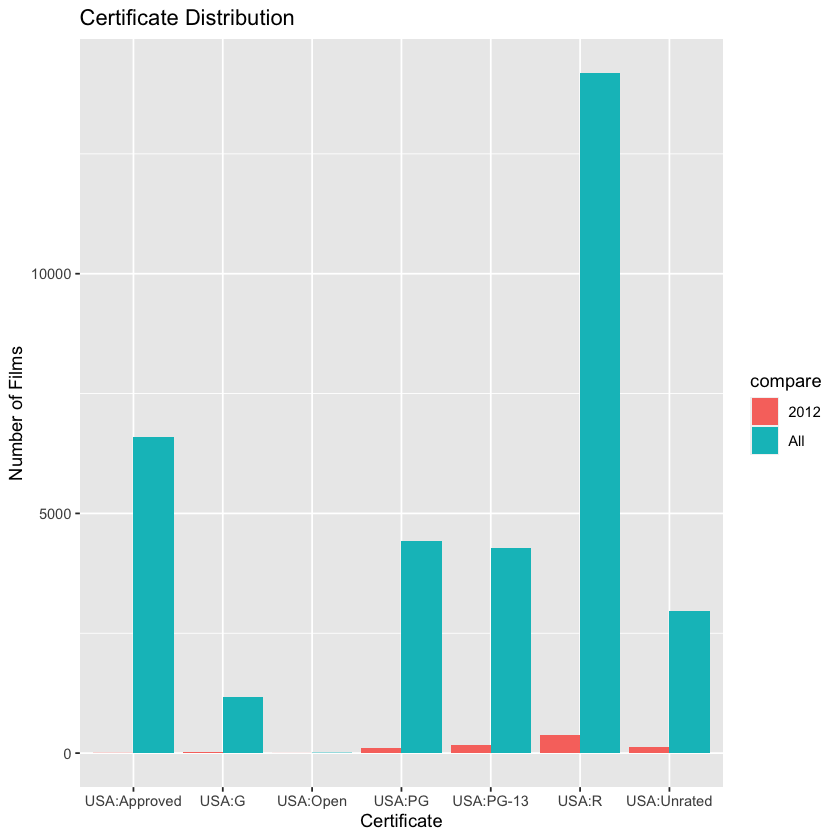

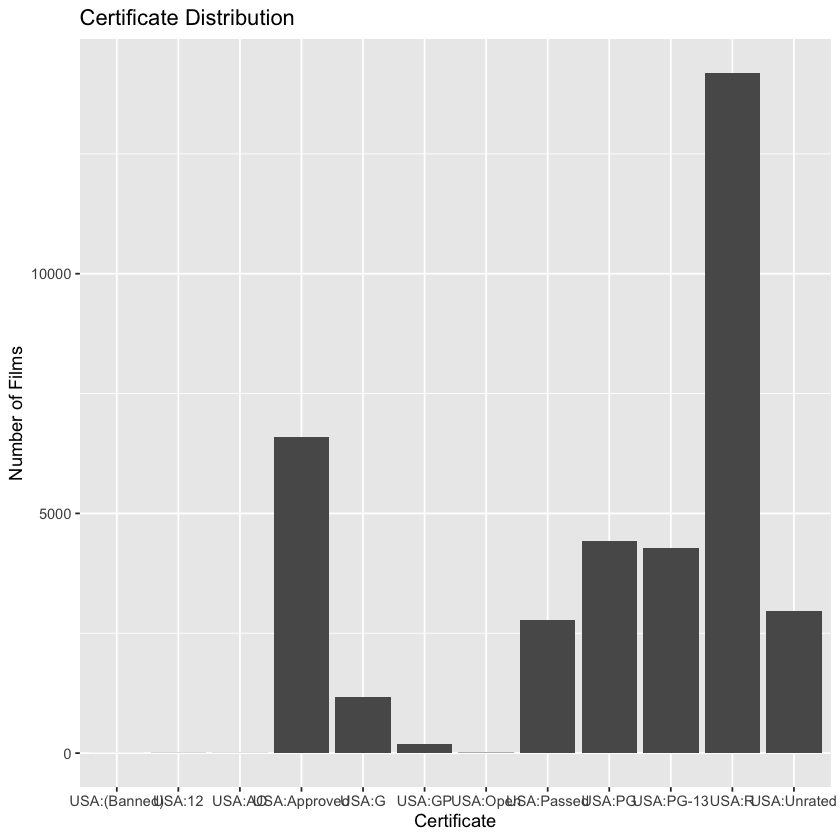

In [60]:
plotCertificatesPerYear(unique_movies, 2012)
plotCertificatesPerYear(unique_movies, NULL)

In [86]:
## Bar chart for distribution of N key words ##

plotTopKeywordsPerYear <- function(data, year, n)
{
    
    if (is.null(year)) # no year given, so all the data
    { 
        keyword_distribution_all = distribution_of_keywords(data, n)
        ggplot(keyword_distribution_all, aes(x=keyword, y=count)) +
        geom_bar(stat='identity', fill = "#f3ce13") + labs(title = "Keyword Distribution", x = "Keyword", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        keyword_distribution_year =  distribution_of_keywords(year_films, n) %>% mutate(compare=year)
        
        keyword_distribution_all = distribution_of_keywords(data, length(unique(data$keyword))) %>%
                                    filter(keyword %in% keyword_distribution_year$keyword) %>% mutate(compare='All') 
        
        combined_data = rbind(keyword_distribution_year, keyword_distribution_all)
        
        ggplot(combined_data, aes(x=keyword, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Keyword Distribution", x = "Keyword", y = "Number of Films")
        
    }
}

Selecting by count



[1] "---- total counted= 1049"
[1] "---- unique keywords= 10"


Selecting by count



[1] "---- total counted= 1750011"
[1] "---- unique keywords= 31305"


Selecting by count



[1] "---- total counted= 56048"
[1] "---- unique keywords= 10"


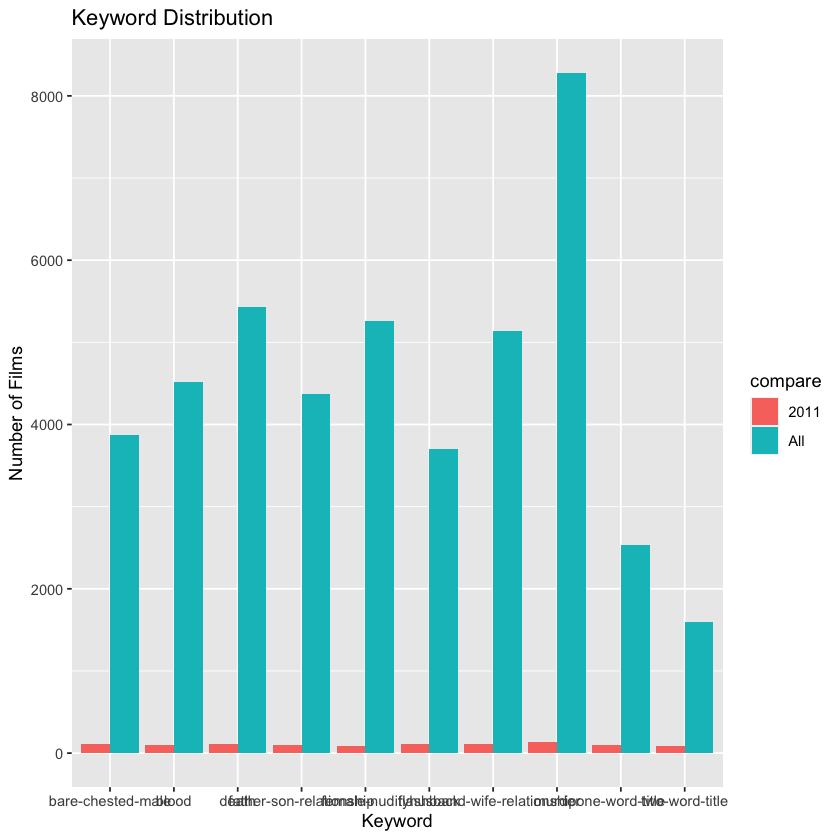

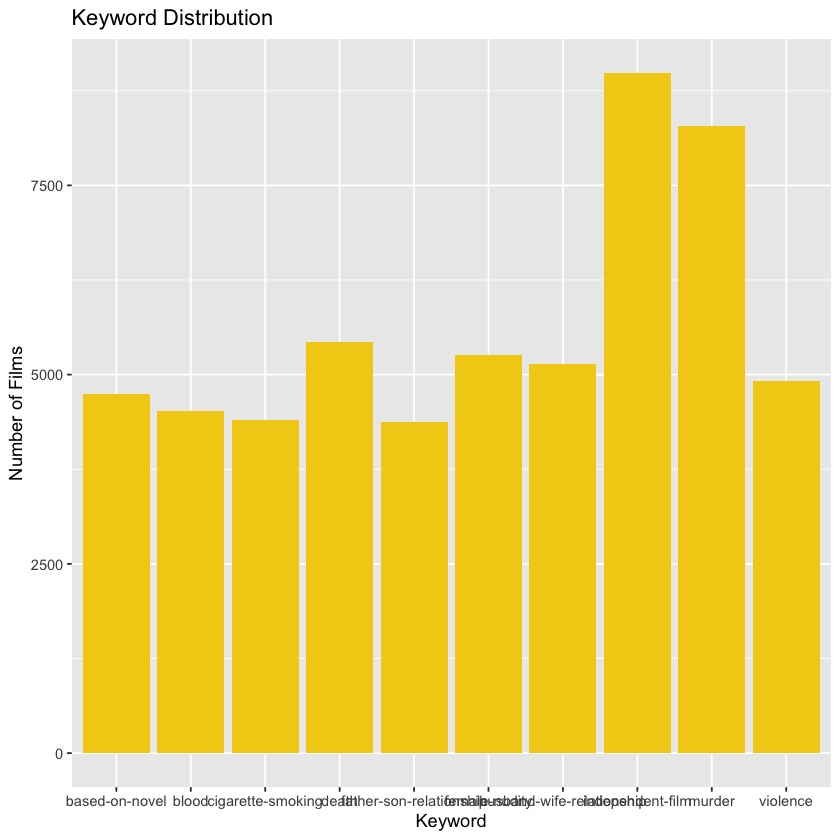

In [87]:
plotTopKeywordsPerYear(keywords_subset, 2011, 10)
plotTopKeywordsPerYear(keywords_subset, NULL, 10)

[1] "---- total counted= 8243"
[1] "---- unique years= 108"


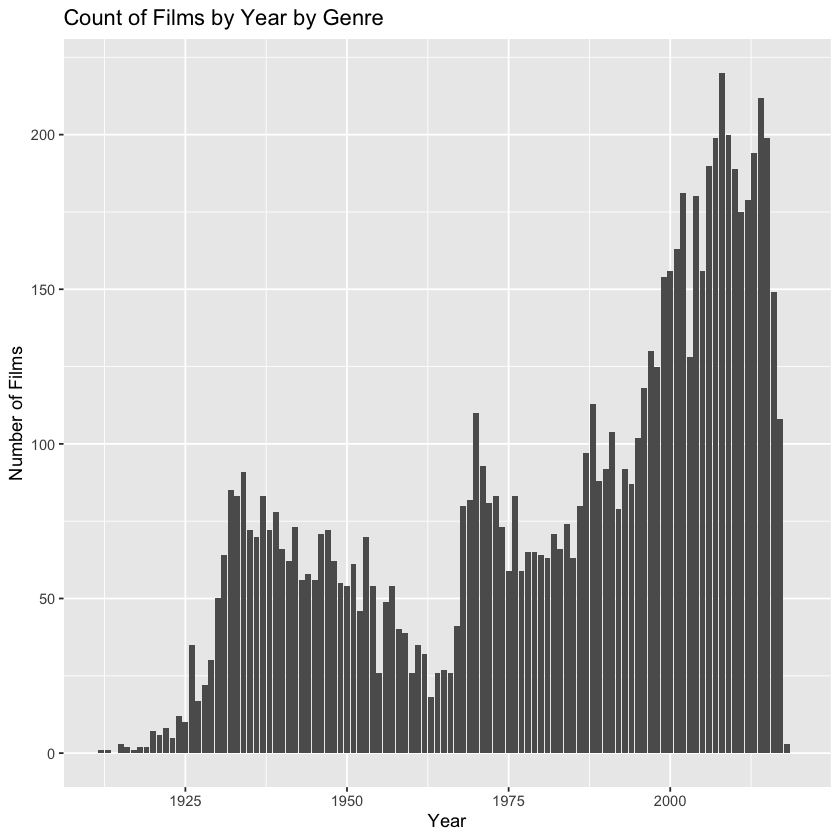

In [63]:
## PLOTTING FUNCTIONS FOR WHEN USER SELECTS BY GENRE

plotYearbyGenre <- function(data, genre)
{
    unique_movies_genre = data[which(data$genre == genre),]
    year_genres_graph = number_films_per_year(unique_movies_genre)

    ggplot(year_genres_graph, aes(x= year, y=count)) + geom_bar(stat = "identity", fill = "gray36") + labs(title = "Count of Films by Year by Genre", x = "Year", y = "Number of Films")
}

plotYearbyGenre(unique_movies, "Drama")

[1] "---- total counted= 8243"
[1] "---- unique decades= 11"


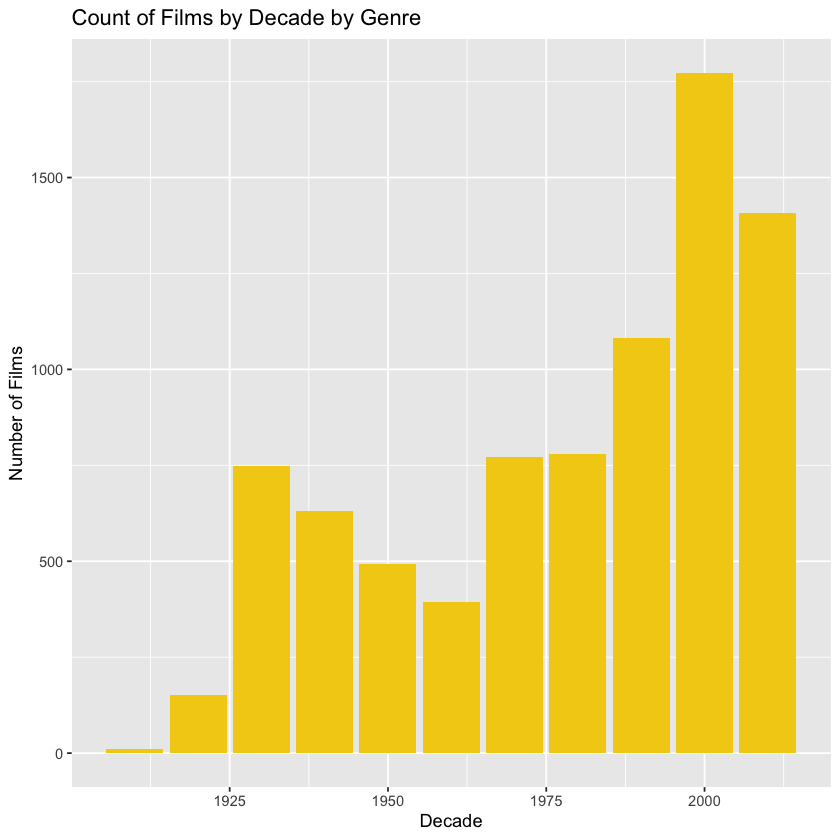

In [64]:
plotDecadebyGenre <- function(data, genre)
{
    unique_movies_genre = data[which(data$genre == genre),]
    decade_genres_graph = number_films_per_decade(unique_movies_genre)

    ggplot(decade_genres_graph, aes(x= decade, y=count)) + geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Count of Films by Decade by Genre", x = "Decade", y = "Number of Films")
}

plotDecadebyGenre(unique_movies, "Drama")

[1] "---- total counted= 8243"
[1] "---- unique months= 12"


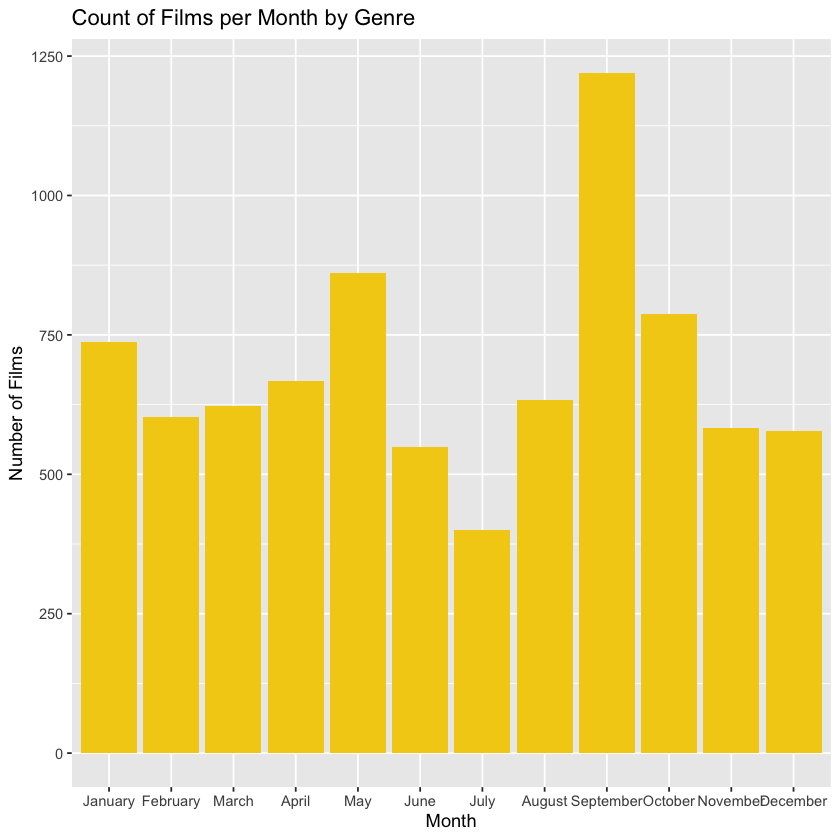

In [65]:
plotMonthbyGenre <- function(data, genre)
{
    unique_movies_genre = data[which(data$genre == genre),]
    month_genres_graph = number_films_per_month(unique_movies_genre)

    ggplot(month_genres_graph, aes(x= month, y=count)) + geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Count of Films per Month by Genre", x = "Month", y = "Number of Films")
}

plotMonthbyGenre(unique_movies, "Drama")

[1] "---- total counted= 8243"
[1] "---- unique years= 108"


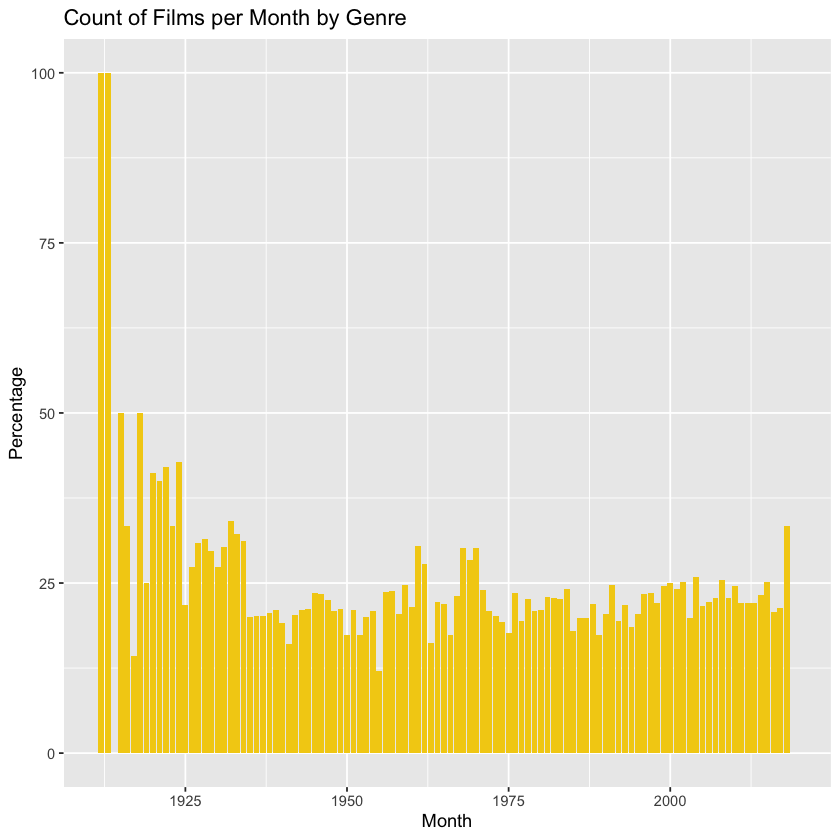

In [66]:
PlotYearPercentageByGenre <- function(data, genre)
{
    unique_movies_genre = data[which(data$genre == genre),]
    year_genres_graph = number_films_per_year(unique_movies_genre)
    
    year_genres_graph$total <- by_year$count
    year_genres_graph$percent <- (year_genres_graph$count / by_year$count) * 100

    ggplot(year_genres_graph, aes(x= year, y=percent)) + geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Count of Films per Month by Genre", x = "Month", y = "Percentage")
}

PlotYearPercentageByGenre(unique_movies, "Drama")

[1] "---- total counted= 8243"
[1] "---- unique decades= 11"


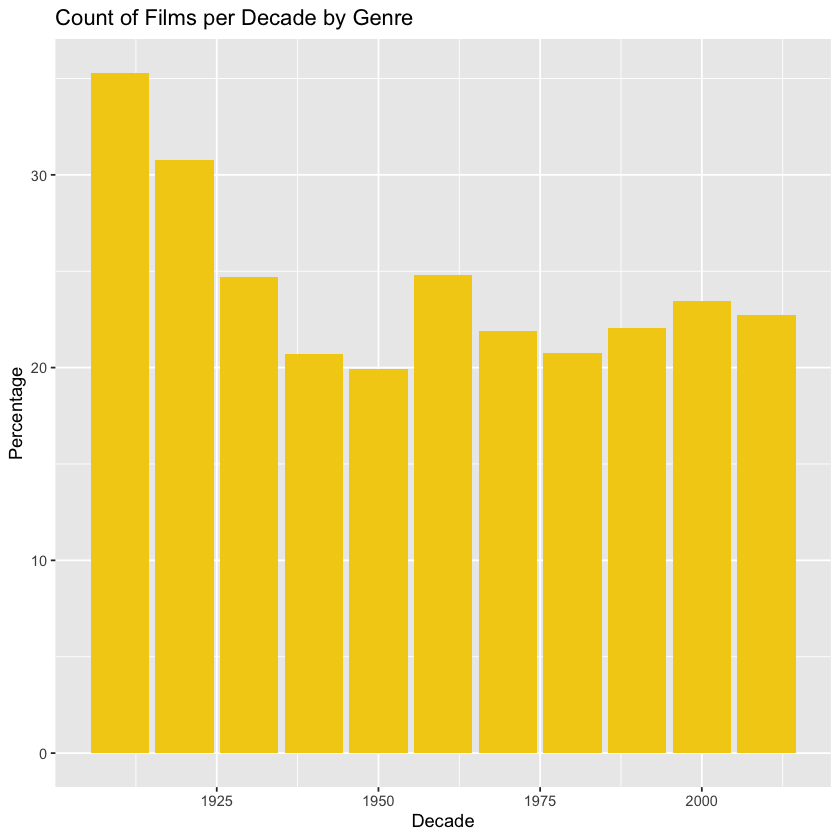

In [67]:
PlotDecadePercentageByGenre <- function(data, genre)
{
    unique_movies_genre = data[which(data$genre == genre),]
    decade_genres_graph = number_films_per_decade(unique_movies_genre)
    
    decade_genres_graph$total <- by_decade$count
    decade_genres_graph$percent <- (decade_genres_graph$count / by_decade$count) * 100

    ggplot(decade_genres_graph, aes(x= decade, y=percent)) + geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Count of Films per Decade by Genre", x = "Decade", y = "Percentage")
}

PlotDecadePercentageByGenre(unique_movies, "Drama")

[1] "---- total counted= 8243"
[1] "---- unique months= 12"


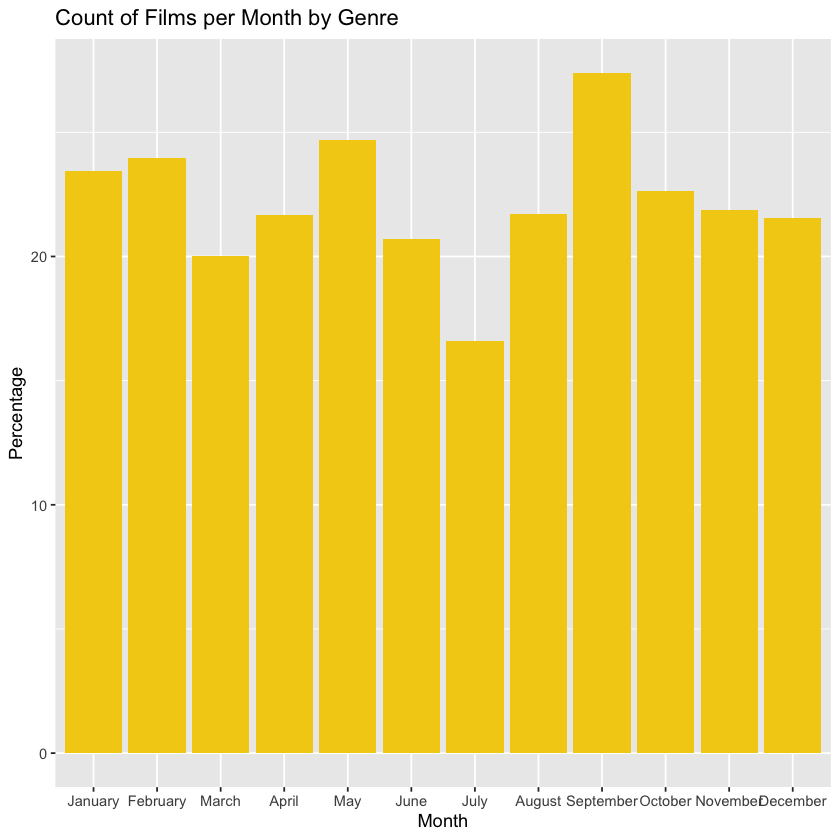

In [68]:
PlotMonthPercentageByGenre <- function(data, genre)
{
    unique_movies_genre = data[which(data$genre == genre),]
    month_genres_graph = number_films_per_month(unique_movies_genre)
    
    month_genres_graph$total <- by_month$count
    month_genres_graph$percent <- (month_genres_graph$count / by_month$count) * 100

    ggplot(month_genres_graph, aes(x= month, y=percent)) + geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Count of Films per Month by Genre", x = "Month", y = "Percentage")
}

PlotMonthPercentageByGenre(unique_movies, "Drama")